In [1]:
# Importing libraries. 
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm

# To avoid non-essential warnings 
import warnings
warnings.filterwarnings('ignore')

from torchvision import datasets, transforms, models 
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import warnings

warnings.filterwarnings('ignore')

# Use local GPU instead of Google Colab
data_dir = "animal/dataset/dataset"
classes = os.listdir(data_dir)

In [3]:
# Performing Image Transformations. 
# Hints: Data Augmentation can be applied here. Have a look on RandomFlip, RandomRotation...
train_transform = transforms.Compose([
            transforms.Resize(112),
            transforms.RandomHorizontalFlip(),
            transforms.CenterCrop(112),
            transforms.ToTensor(),
            transforms.Normalize((0.488), (0.2172)),
        ])

# Checking the dataset training size.
dataset = ImageFolder(data_dir, transform=train_transform)
print('Size of training dataset :', len(dataset))

# Viewing one of images shape.
img, label = dataset[100]
print(f"Image shape: {img.shape}")

Size of training dataset : 6270
Image shape: torch.Size([3, 112, 112])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1745567..2.3031092].


Label:  ailurus-fulgens (5)


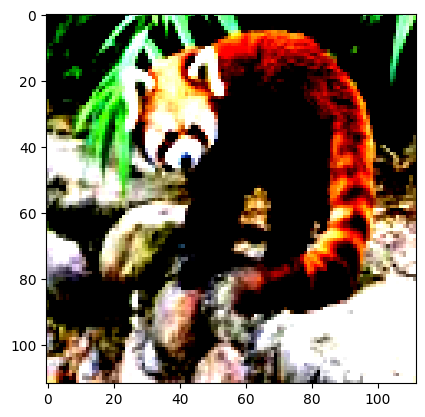

In [4]:
# Preview one of the images..
def show_image(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1,2,0))

show_image(*dataset[200])

In [5]:
import random

# Set the random seed for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

In [6]:
# Setting seed so that value won't change everytime. 
# Splitting the dataset to training, validation, and testing category.
set_seed(42)

val_size = len(dataset) // 20
test_size = len(dataset) // 10
train_size = len(dataset) - val_size - test_size

# Random Splitting. 
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
len(train_ds), len(val_ds),len(test_ds)  

(5330, 313, 627)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.2467773..2.3572743].


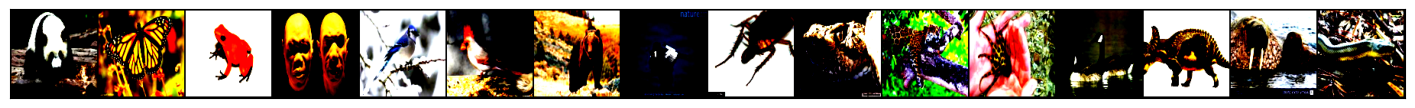

In [7]:
batch_size = 16
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size, num_workers=2, pin_memory=True)

# Multiple images preview. 
for images, labels in train_loader:
    fig, ax = plt.subplots(figsize=(18,10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
    break

In [8]:
# Baseline model class for training and validation purpose. Evaluation metric function - Accuracy.
def accuracy(output, target, topk=(1,)):
    """
    Computes the accuracy over the k top predictions for the specified values of k
    In top-3 accuracy you give yourself credit for having the right answer
    if the right answer appears in your top three guesses.
    """
    with torch.no_grad():
        maxk = 3
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()

        correct = (pred == target.unsqueeze(dim=0)).expand_as(pred)

        correct_3 = correct[:3].reshape(-1).float().sum(0, keepdim=True)

        return correct_3.mul_(1.0 / batch_size)


class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss, Hints: the loss function can be changed to improve the accuracy
        acc = accuracy(out, labels, (1,)) # return both 
        return {'train_loss': loss, 'train_acc': acc}
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels, (5))           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, train_acc: {:.4f}, val_acc: {:.4f}".format(
            epoch+1, result['train_loss'], result['val_loss'], result['train_acc'], result['val_acc']))

**Notice:**
- In the `training_step` function I modified the code a little bit, to let the train return both training accuracy and loss, instead of just return the loss. And in function `epoch_end` I print the training accuracy.

In [9]:
 # To check wether Google Colab GPU has been assigned/not. 
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return None
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)
    
device = get_default_device()
print(device)

cuda


### Baseline model

In [10]:
# Convolutional Network - Baseline
class ConvolutionalNetwork(ImageClassificationBase):
    def __init__(self, classes):
        super().__init__()
        self.num_classes=classes
        self.conv1=nn.Conv2d(3,64,5,1)
        self.conv2=nn.Conv2d(64,128,3,1)
        self.conv3=nn.Conv2d(128,128,3,1)
        self.conv4=nn.Conv2d(128,128,3,1)
        self.fc1=nn.Linear(128*5*5,self.num_classes)
    def forward(self,X):
        X=F.relu(self.conv1(X))
        X=F.max_pool2d(X,2,2)
        X=F.relu(self.conv2(X))
        X=F.max_pool2d(X,2,2)
        X=F.relu(self.conv3(X))
        X=F.max_pool2d(X,2,2)
        X=F.relu(self.conv4(X))
        X=F.max_pool2d(X,2,2)
        X=X.view(-1,128*5*5)
        X=self.fc1(X)
        
        return F.log_softmax(X, dim=1)

In [11]:
# Model print
num_classes = 151
model = ConvolutionalNetwork(num_classes)

# set up data loader
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

model = to_device(model, device)
model

ConvolutionalNetwork(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=3200, out_features=151, bias=True)
)

In [12]:
# We can check the input and the output shape
for images, labels in train_loader:
    out = model(images)
    print('images.shape:', images.shape)    
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([16, 3, 112, 112])
out.shape: torch.Size([16, 151])
out[0]: tensor([-5.0330, -5.0304, -5.0173, -4.9921, -5.0377, -5.0028, -5.0308, -4.9716,
        -4.9510, -5.0031, -5.0243, -5.0337, -5.0463, -5.0406, -4.9950, -4.9499,
        -5.0462, -5.0435, -5.0321, -5.0747, -4.9957, -5.0128, -5.0194, -5.0369,
        -5.0000, -5.0023, -4.9400, -5.0418, -4.9725, -5.0005, -4.9809, -5.0254,
        -4.9562, -5.0289, -4.9446, -4.9725, -5.0738, -5.0004, -4.9788, -5.0104,
        -4.9815, -5.0167, -4.9924, -5.0690, -5.0053, -5.0041, -4.9812, -5.0109,
        -5.0153, -5.0320, -5.0232, -5.0164, -5.1000, -5.0366, -4.9501, -5.0584,
        -5.0446, -4.9780, -4.9509, -5.0156, -5.0607, -5.0596, -5.0116, -4.9944,
        -4.9863, -4.9938, -5.0141, -5.0161, -5.0435, -5.0470, -4.9844, -5.0580,
        -5.0133, -4.9939, -5.0568, -5.0446, -5.0566, -4.9752, -4.9958, -5.0605,
        -4.9952, -5.0207, -5.0145, -5.0777, -5.0375, -4.9840, -5.0064, -5.0902,
        -4.9951, -5.0508, -5.0038, 

In [13]:
# Functions for evaluation and training.

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        train_accs = []
        for batch in tqdm(train_loader):
            result = model.training_step(batch)
            loss = result['train_loss']
            acc = result['train_acc']
            train_losses.append(loss)
            train_accs.append(acc)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_acc'] = torch.stack(train_accs).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [14]:
# Hints: The following parameters can be changed to improve the accuracy
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001 # Hints: The following parameters can be changed to improve the accuracy

history = []
history += fit(num_epochs, lr, model, train_loader, val_loader, opt_func)

  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [1], train_loss: 4.8508, val_loss: 4.5725, train_acc: 0.0556, val_acc: 0.1111


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [2], train_loss: 4.3940, val_loss: 4.2944, train_acc: 0.1463, val_acc: 0.1580


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [3], train_loss: 3.9313, val_loss: 4.0100, train_acc: 0.2509, val_acc: 0.2681


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [4], train_loss: 3.4889, val_loss: 3.8528, train_acc: 0.3583, val_acc: 0.2892


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [5], train_loss: 3.0617, val_loss: 3.7994, train_acc: 0.4680, val_acc: 0.3205


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [6], train_loss: 2.6592, val_loss: 4.0149, train_acc: 0.5533, val_acc: 0.3149


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [7], train_loss: 2.3322, val_loss: 4.1782, train_acc: 0.6231, val_acc: 0.3535


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [8], train_loss: 2.0355, val_loss: 4.2973, train_acc: 0.6832, val_acc: 0.3142


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [9], train_loss: 1.7400, val_loss: 4.6924, train_acc: 0.7403, val_acc: 0.3611


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [10], train_loss: 1.5222, val_loss: 4.6414, train_acc: 0.7863, val_acc: 0.3486


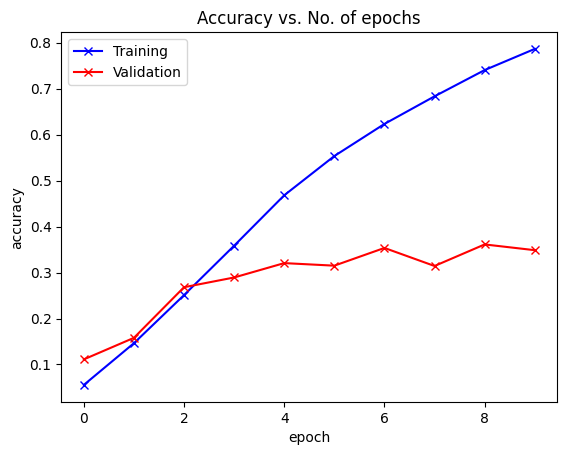

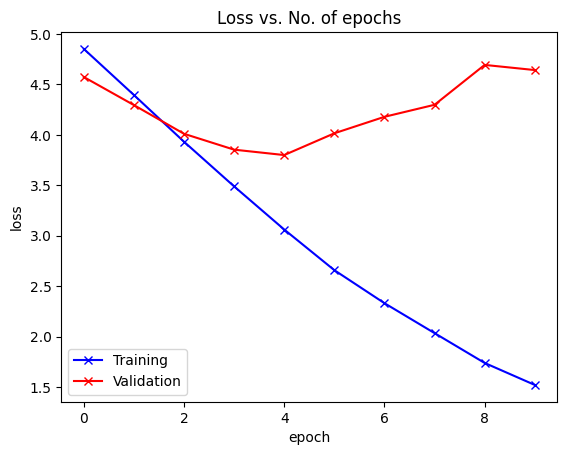

In [15]:
# plot the history of accuracy and loss
def plot_accuracies(history):
    train_accuracies = [x.get('train_acc') for x in history]
    val_accuracies = [x['val_acc'] for x in history]
    plt.plot(train_accuracies, '-bx')
    plt.plot(val_accuracies, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['Training', 'Validation'])
    plt.title('Accuracy vs. No. of epochs')
    plt.show()
    
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    plt.show()

plot_accuracies(history)
plot_losses(history)

In [16]:
def get_gflops(model, input_size):
    from fvcore.nn.flop_count import FlopCountAnalysis

    input_tensor = torch.randn(1, 3, input_size, input_size)

    gflops = FlopCountAnalysis(model, input_tensor).total() / 1e9

    return round(gflops, 6)


In [17]:
test_accuracy_baseline = evaluate(model, test_loader)['val_acc']
print(f"Test accuracy for baseline model: {round(test_accuracy_baseline * 100, 4)}%")


Test accuracy for baseline model: 36.0938%


In [18]:
gflops_baseline = get_gflops(ConvolutionalNetwork(151), 112)
print(f"FLOPs for baseline model: {gflops_baseline}(GFLOPs)")

efficiency_baseline = test_accuracy_baseline / gflops_baseline * 100
print(f"Effiency score for baseline model: {efficiency_baseline:6f} (acc%/GFLOPs)")

Unsupported operator aten::max_pool2d encountered 4 time(s)
Unsupported operator aten::log_softmax encountered 1 time(s)


FLOPs for baseline model: 0.355511(GFLOPs)
Effiency score for baseline model: 101.526396 (acc%/GFLOPs)


## Enhanced models

In [19]:
# Data augmentation and transformation
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [20]:
# Checking the dataset training size.
dataset = ImageFolder(data_dir, transform=train_transform)

# set random seed
set_seed(42)

# split the data by size
val_size = len(dataset) // 20
test_size = len(dataset) // 10
train_size = len(dataset) - val_size - test_size

# Random Splitting. 
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

# Apply different transformations to validation and test datasets
val_ds.dataset.transform = val_transform
test_ds.dataset.transform = val_transform

# Data loaders
batch_size = 32
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size, num_workers=2, pin_memory=True)

In [21]:
# set data loader
device = get_default_device()
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [22]:
# Define the model with transfer learning
class Resnet18(ImageClassificationBase):
    def __init__(self, num_classes):
        super(Resnet18, self).__init__()
        self.network = models.resnet18(pretrained=True)
        num_features = self.network.fc.in_features
        self.network.fc = nn.Linear(num_features, num_classes)
    
    def forward(self, x):
        return self.network(x)

In [23]:
# Define the model with transfer learning plus fine tuning
class Resnet18FineTuned(ImageClassificationBase):
    def __init__(self, num_classes):
        super(Resnet18FineTuned, self).__init__()
        self.network = models.resnet18(pretrained=True)
        for param in self.network.parameters():
            param.requires_grad = False
        num_features = self.network.fc.in_features
        self.network.fc = nn.Linear(num_features, num_classes)
    
    def forward(self, x):
        return self.network(x)

In [24]:
# Define smaller model with transfer learning plus fine tuning
class MnasNetFineTuned(ImageClassificationBase):
    def __init__(self, num_classes):
        super(MnasNetFineTuned, self).__init__()
        # Load pre-trained MobileNetV2 model
        self.model = models.mnasnet0_5(pretrained=True)
        
        # Freeze all layers except the final classifier
        for param in self.model.parameters():
            param.requires_grad = False
            
        # Replace the final classifier layer
        in_features = self.model.classifier[1].in_features
        self.model.classifier[1] = nn.Linear(in_features, num_classes)
    
    def forward(self, x):
        return self.model(x)

In [25]:
# Define smaller model with transfer learning plus fine tuning
class ShuffleNetFineTuned(ImageClassificationBase):
    def __init__(self, num_classes):
        super(ShuffleNetFineTuned, self).__init__()
        # Load pre-trained MobileNetV2 model
        self.model = models.shufflenet_v2_x0_5(pretrained=True)
        
        # Freeze all layers except the final classifier
        for param in self.model.parameters():
            param.requires_grad = False
            
        # Replace the final classifier layer
        in_features = self.model.fc.in_features
        self.model.fc = nn.Linear(in_features, num_classes)
    
    def forward(self, x):
        return self.model(x)

In [33]:
def compare_performance(model, lr):
    gflops = get_gflops(model, 224)

    model = model.to(device)

    # Loss function and optimizer
    epochs = 10
    optimizer = torch.optim.Adam

    # store the training history
    history = []
    history += fit(epochs, lr, model, train_loader, val_loader, optimizer)

    # plot performance
    plot_accuracies(history)
    plot_losses(history)

    accuracy = evaluate(model, test_loader)['val_acc']

    flops_ratio = gflops / gflops_baseline
    accuracy_improved = accuracy - test_accuracy_baseline
    accuracy_ratio = accuracy / test_accuracy_baseline

    efficiency = accuracy / gflops * 100
    efficiency_ratio = efficiency / efficiency_baseline

    print(f"Final accuracy: {round(accuracy * 100, 4)}%")
    print(f"Model FLOPs: {gflops}(GFLOPs)\n")

    print(f"FLOPs ratio with baseline model: {round(flops_ratio)}")
    print(f"Accuracy improved: {round(accuracy_improved * 100, 4)}%")
    print(f"Model achieved accuracy {round(accuracy_ratio, 4)} times better than baseline model\n")

    print(f"Model efficiency: {efficiency} (acc%/GFLOPs)")
    print(f"Model has efficiency {round(efficiency_ratio, 4)} times better than baseline model")

Unsupported operator aten::add_ encountered 28 time(s)


Training ResNet18 without fine tune.....


Unsupported operator aten::max_pool2d encountered 1 time(s)


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [1], train_loss: 3.1607, val_loss: 2.7224, train_acc: 0.4739, val_acc: 0.5628


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [2], train_loss: 1.5527, val_loss: 2.1008, train_acc: 0.7939, val_acc: 0.6921


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [3], train_loss: 0.8784, val_loss: 1.9412, train_acc: 0.9113, val_acc: 0.7283


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [4], train_loss: 0.4898, val_loss: 2.0189, train_acc: 0.9704, val_acc: 0.7274


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [5], train_loss: 0.2685, val_loss: 1.6805, train_acc: 0.9871, val_acc: 0.7823


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [6], train_loss: 0.1456, val_loss: 1.5742, train_acc: 0.9968, val_acc: 0.8161


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [7], train_loss: 0.1389, val_loss: 1.6077, train_acc: 0.9982, val_acc: 0.7925


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [8], train_loss: 0.1986, val_loss: 2.0179, train_acc: 0.9921, val_acc: 0.7180


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [9], train_loss: 0.1760, val_loss: 1.8759, train_acc: 0.9925, val_acc: 0.7706


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [10], train_loss: 0.1687, val_loss: 2.0770, train_acc: 0.9931, val_acc: 0.7434


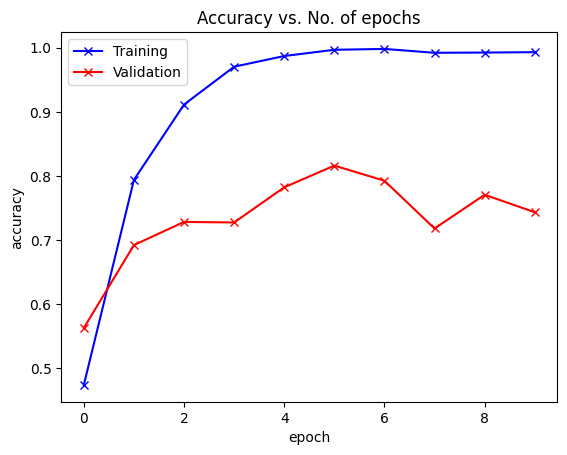

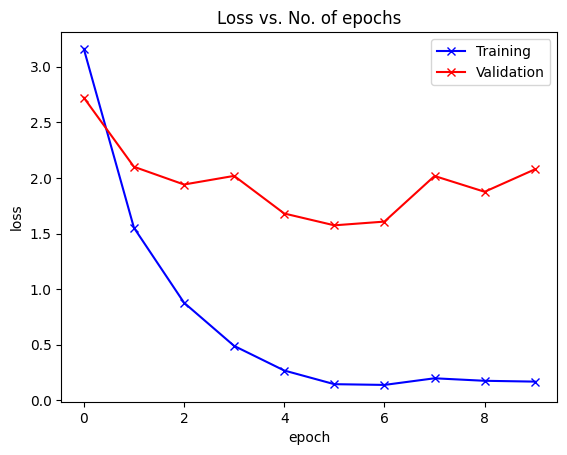

Final accuracy: 75.6086%
Model FLOPs: 1.826082(GFLOPs)

FLOPs ratio with baseline model: 5
Accuracy improved: 39.5148%
Model achieved accuracy 2.0948 times better than baseline model

Model efficiency: 41.40479861402295 (acc%/GFLOPs)
Model has efficiency 0.4078 times better than baseline model


In [35]:
print("Training ResNet18 without fine tune.....")
compare_performance(Resnet18(num_classes), 0.001)

Training ResNet18 with fine tune.....


Unsupported operator aten::add_ encountered 28 time(s)
Unsupported operator aten::max_pool2d encountered 1 time(s)


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [1], train_loss: 3.0099, val_loss: 1.5072, train_acc: 0.5950, val_acc: 0.8639


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [2], train_loss: 1.0313, val_loss: 0.8602, train_acc: 0.9440, val_acc: 0.9500


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [3], train_loss: 0.6183, val_loss: 0.6977, train_acc: 0.9738, val_acc: 0.9420


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [4], train_loss: 0.4383, val_loss: 0.5940, train_acc: 0.9824, val_acc: 0.9719


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [5], train_loss: 0.3353, val_loss: 0.5634, train_acc: 0.9900, val_acc: 0.9563


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [6], train_loss: 0.2621, val_loss: 0.5026, train_acc: 0.9933, val_acc: 0.9656


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [7], train_loss: 0.2176, val_loss: 0.4953, train_acc: 0.9961, val_acc: 0.9656


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [8], train_loss: 0.1761, val_loss: 0.4837, train_acc: 0.9978, val_acc: 0.9656


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [9], train_loss: 0.1479, val_loss: 0.5000, train_acc: 0.9983, val_acc: 0.9625


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [10], train_loss: 0.1241, val_loss: 0.4714, train_acc: 0.9993, val_acc: 0.9594


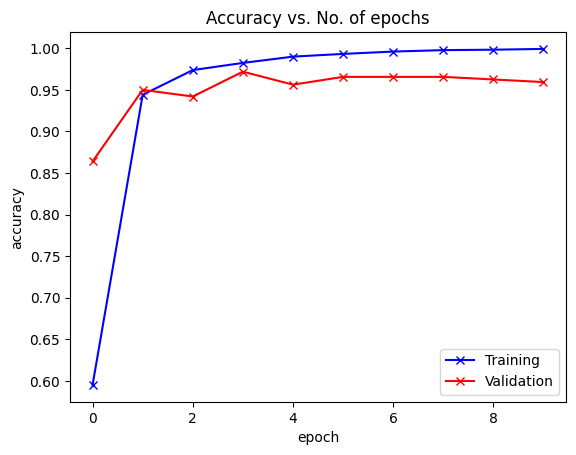

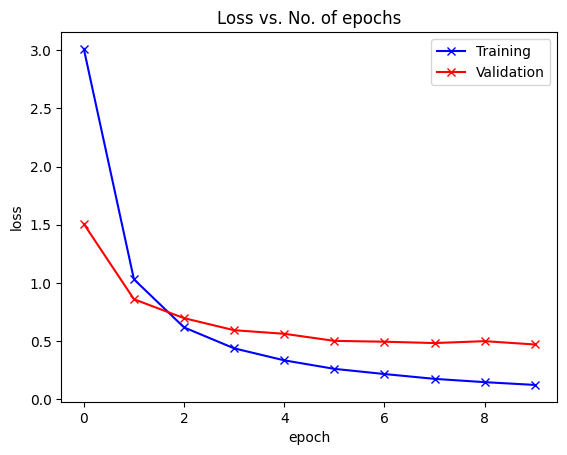

Final accuracy: 96.0938%
Model FLOPs: 1.826082(GFLOPs)

FLOPs ratio with baseline model: 5
Accuracy improved: 60.0%
Model achieved accuracy 2.6623 times better than baseline model

Model efficiency: 52.622910690757585 (acc%/GFLOPs)
Model has efficiency 0.5183 times better than baseline model


In [28]:
print("Training ResNet18 with fine tune.....")
compare_performance(Resnet18FineTuned(num_classes), 0.001)

Training MnasNet with fine tune.....


Unsupported operator aten::add_ encountered 52 time(s)
Unsupported operator aten::add encountered 10 time(s)
Unsupported operator aten::mean encountered 1 time(s)
Unsupported operator aten::dropout_ encountered 1 time(s)


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [1], train_loss: 4.4945, val_loss: 4.0128, train_acc: 0.3942, val_acc: 0.7149


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [2], train_loss: 3.4862, val_loss: 3.2878, train_acc: 0.8346, val_acc: 0.8505


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [3], train_loss: 2.7568, val_loss: 2.7322, train_acc: 0.9218, val_acc: 0.8983


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [4], train_loss: 2.1970, val_loss: 2.3080, train_acc: 0.9459, val_acc: 0.9014


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [5], train_loss: 1.7989, val_loss: 1.9888, train_acc: 0.9615, val_acc: 0.9139


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [6], train_loss: 1.4957, val_loss: 1.7470, train_acc: 0.9692, val_acc: 0.9241


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [7], train_loss: 1.2645, val_loss: 1.5571, train_acc: 0.9738, val_acc: 0.9295


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [8], train_loss: 1.0883, val_loss: 1.4144, train_acc: 0.9807, val_acc: 0.9366


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [9], train_loss: 0.9539, val_loss: 1.2939, train_acc: 0.9828, val_acc: 0.9366


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [10], train_loss: 0.8423, val_loss: 1.2051, train_acc: 0.9867, val_acc: 0.9398


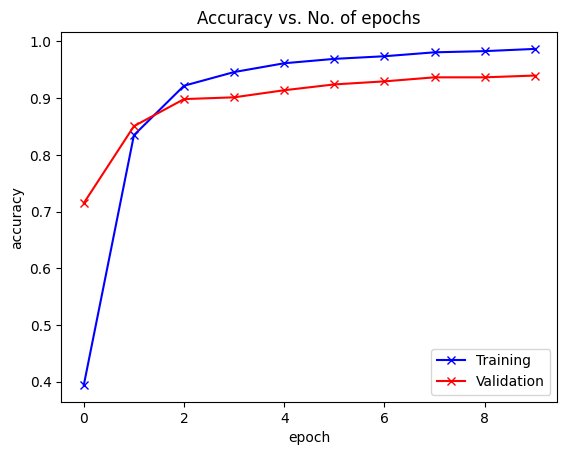

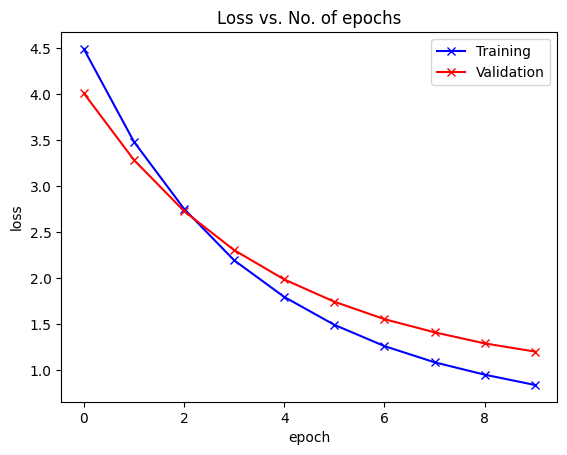

Final accuracy: 93.9556%
Model FLOPs: 0.118696(GFLOPs)

FLOPs ratio with baseline model: 0
Accuracy improved: 57.8618%
Model achieved accuracy 2.6031 times better than baseline model

Model efficiency: 791.5649583913844 (acc%/GFLOPs)
Model has efficiency 7.7966 times better than baseline model


In [29]:
print("Training MnasNet with fine tune.....")
compare_performance(MnasNetFineTuned(num_classes), 0.001)

Training MnasNet with fine tune.....


Unsupported operator aten::add_ encountered 52 time(s)
Unsupported operator aten::add encountered 10 time(s)
Unsupported operator aten::mean encountered 1 time(s)
Unsupported operator aten::dropout_ encountered 1 time(s)


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [1], train_loss: 2.4889, val_loss: 1.1771, train_acc: 0.6785, val_acc: 0.9210


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [2], train_loss: 0.6405, val_loss: 0.9066, train_acc: 0.9665, val_acc: 0.9366


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [3], train_loss: 0.3433, val_loss: 0.8206, train_acc: 0.9886, val_acc: 0.9335


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [4], train_loss: 0.2117, val_loss: 0.7391, train_acc: 0.9969, val_acc: 0.9429


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [5], train_loss: 0.1455, val_loss: 0.6983, train_acc: 0.9989, val_acc: 0.9398


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [6], train_loss: 0.1067, val_loss: 0.6855, train_acc: 0.9998, val_acc: 0.9491


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [7], train_loss: 0.0866, val_loss: 0.6792, train_acc: 1.0000, val_acc: 0.9491


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [8], train_loss: 0.0626, val_loss: 0.6505, train_acc: 1.0000, val_acc: 0.9429


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [9], train_loss: 0.0559, val_loss: 0.6530, train_acc: 1.0000, val_acc: 0.9366


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [10], train_loss: 0.0473, val_loss: 0.6320, train_acc: 1.0000, val_acc: 0.9366


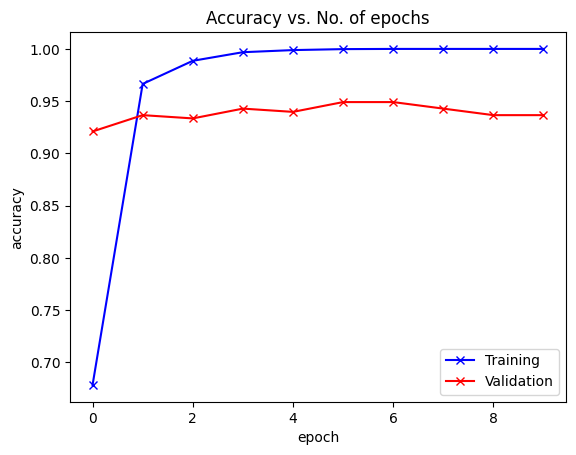

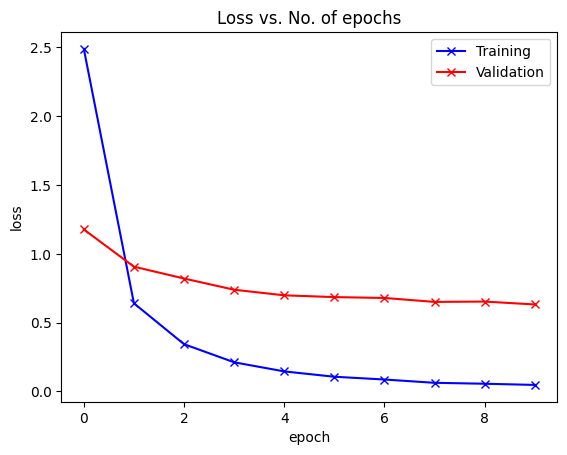

Final accuracy: 94.8438%
Model FLOPs: 0.118696(GFLOPs)

FLOPs ratio with baseline model: 0
Accuracy improved: 58.75%
Model achieved accuracy 2.6277 times better than baseline model

Model efficiency: 799.0475769368209 (acc%/GFLOPs)
Model has efficiency 7.8703 times better than baseline model


In [30]:
print("Training MnasNet with fine tune.....")
compare_performance(MnasNetFineTuned(num_classes), 0.01)

Training ShuffleNet with fine tune.....
Unsupported operator aten::add_ encountered 56 time(s)
Unsupported operator aten::max_pool2d encountered 1 time(s)
Unsupported operator aten::mean encountered 1 time(s)
The following submodules of the model were never called during the trace of the graph. They may be unused, or they were accessed by direct calls to .forward() or via other python methods. In the latter case they will have zeros for statistics, though their statistics will still contribute to their parent calling module.
model.stage2.1.branch1, model.stage2.2.branch1, model.stage2.3.branch1, model.stage3.1.branch1, model.stage3.2.branch1, model.stage3.3.branch1, model.stage3.4.branch1, model.stage3.5.branch1, model.stage3.6.branch1, model.stage3.7.branch1, model.stage4.1.branch1, model.stage4.2.branch1, model.stage4.3.branch1


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [1], train_loss: 2.4785, val_loss: 1.2648, train_acc: 0.6778, val_acc: 0.8826


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [2], train_loss: 0.6495, val_loss: 0.9262, train_acc: 0.9654, val_acc: 0.9295


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [3], train_loss: 0.3470, val_loss: 0.8069, train_acc: 0.9891, val_acc: 0.9398


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [4], train_loss: 0.2202, val_loss: 0.7555, train_acc: 0.9963, val_acc: 0.9366


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [5], train_loss: 0.1461, val_loss: 0.7410, train_acc: 0.9994, val_acc: 0.9326


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [6], train_loss: 0.1112, val_loss: 0.6766, train_acc: 0.9996, val_acc: 0.9491


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [7], train_loss: 0.0803, val_loss: 0.6507, train_acc: 1.0000, val_acc: 0.9460


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [8], train_loss: 0.0702, val_loss: 0.6718, train_acc: 1.0000, val_acc: 0.9358


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [9], train_loss: 0.0551, val_loss: 0.6514, train_acc: 1.0000, val_acc: 0.9398


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [10], train_loss: 0.0481, val_loss: 0.6223, train_acc: 1.0000, val_acc: 0.9491


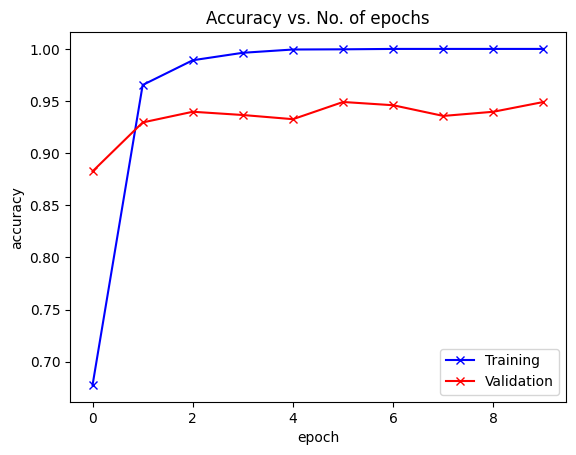

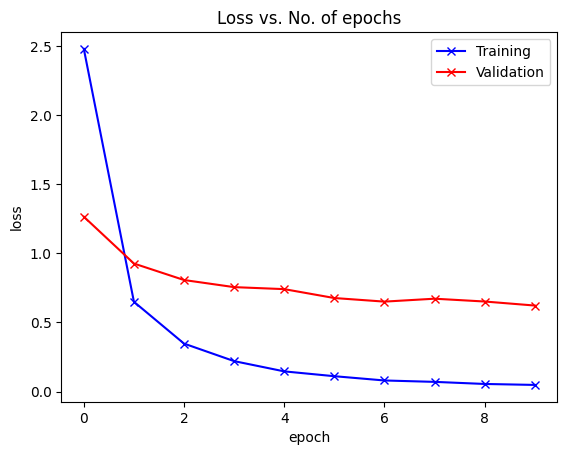

Final accuracy: 94.0625%
Model FLOPs: 0.044727(GFLOPs)

FLOPs ratio with baseline model: 0
Accuracy improved: 57.9688%
Model achieved accuracy 2.6061 times better than baseline model

Model efficiency: 2103.0362240278328 (acc%/GFLOPs)
Model has efficiency 20.7142 times better than baseline model


In [32]:
print("Training ShuffleNet with fine tune.....")
compare_performance(ShuffleNetFineTuned(num_classes), 0.02)